<a href="https://colab.research.google.com/github/hazem1379/routing-Animation/blob/master/From_IKEA_to_DU_Borl%C3%A4nge_Routing_Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 32 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2

In [0]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [0]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

/usr/local/lib/python3.6/dist-packages/osmnx/plot.py:55: UserWarning:

The fig_height, fig_width parameter(s) have been deprecated and will be removed in the next release. Note, fig_height and fig_width are replaced by the figsize parameter, use that instead. 



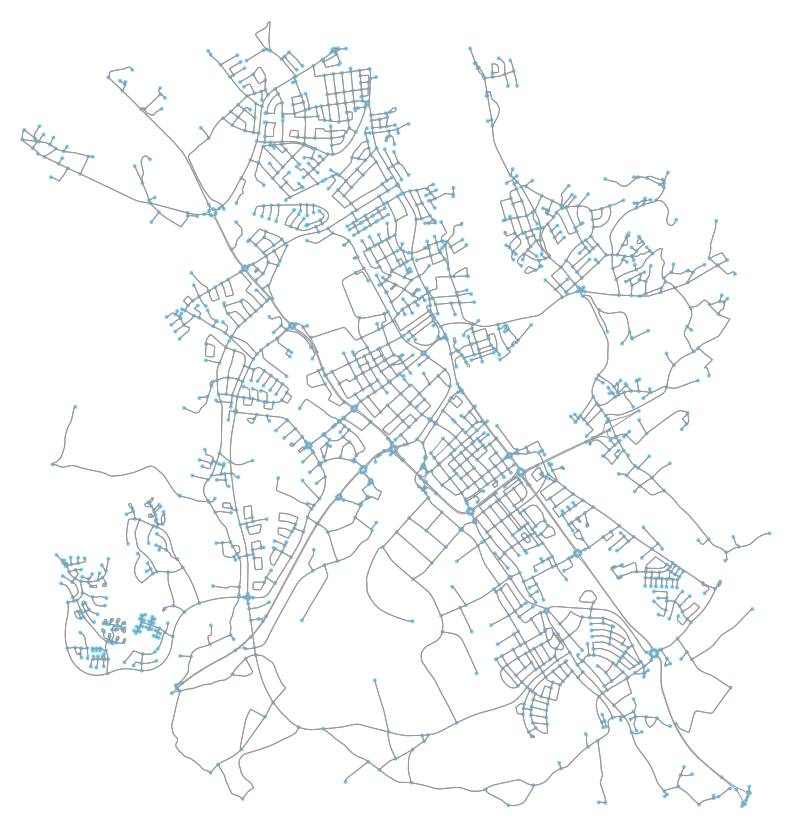

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f77fa0e75c0>)

In [4]:
G = create_graph("Borlänge", 4000, "drive")
ox.plot_graph(G,fig_width=15, fig_height=15)

In [0]:
# impute missing edge speeds and add travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [0]:
start = (60.4820,15.4225)
end = (60.6144, 15.6534)
start_node = ox.get_nearest_node(G, start) 
end_node = ox.get_nearest_node(G, end)
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
    


/usr/local/lib/python3.6/dist-packages/osmnx/plot.py:55: UserWarning:

The fig_height, fig_width parameter(s) have been deprecated and will be removed in the next release. Note, fig_height and fig_width are replaced by the figsize parameter, use that instead. 



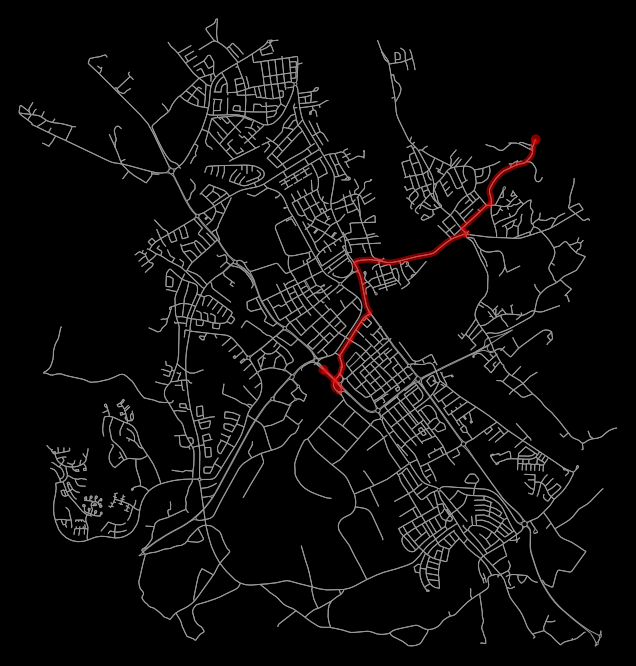

In [7]:
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k',fig_width=12, fig_height=12 );

In [0]:
nx.shortest_path_length?

In [9]:
#see the travel time for the whole route
travel_time = nx.shortest_path_length(G, start_node, end_node, weight='travel_time')
print(round(travel_time))

456


In [0]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route[:-1], route[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [11]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,8081673,8078064,15.423709,60.482554,15.427144,60.480906,263,16
1,8078064,19833132,15.427144,60.480906,15.427959,60.480063,108,10
2,19833132,19833135,15.427959,60.480063,15.426853,60.480093,66,4
3,19833135,4754340232,15.426853,60.480093,15.427309,60.481798,222,20
4,4754340232,4754340224,15.427309,60.481798,15.427424,60.481862,9,1


In [12]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,8081673,8078064,15.423709,60.482554,15.427144,60.480906,263,16
1,1,8078064,19833132,15.427144,60.480906,15.427959,60.480063,108,10
2,2,19833132,19833135,15.427959,60.480063,15.426853,60.480093,66,4
3,3,19833135,4754340232,15.426853,60.480093,15.427309,60.481798,222,20
4,4,4754340232,4754340224,15.427309,60.481798,15.427424,60.481862,9,1


In [0]:
def create_line_gdf(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
    gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
    gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
    line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')
    return line_gdf

In [0]:
line_gdf = create_line_gdf(df)

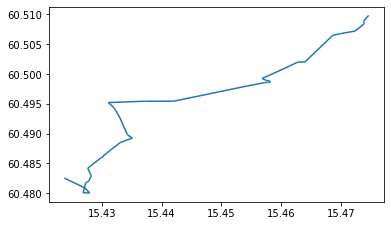

In [15]:
line_gdf.plot()

In [16]:
line_gdf.head()

,node_start,node_end,length,travel_time,line
0,8081673,8078064,263,16,"LINESTRING (15.42714 60.48091, 15.42371 60.48255)"
1,8078064,19833132,108,10,"LINESTRING (15.42796 60.48006, 15.42714 60.48091)"
2,19833132,19833135,66,4,"LINESTRING (15.42685 60.48009, 15.42796 60.48006)"
3,19833135,4754340232,222,20,"LINESTRING (15.42731 60.48180, 15.42685 60.48009)"
4,4754340232,4754340224,9,1,"LINESTRING (15.42742 60.48186, 15.42731 60.48180)"


In [17]:
df.tail()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
45,45,551585558,290246384,15.469914,60.506726,15.472383,60.507154,145,13,POINT (15.46991 60.50673),POINT (15.4723833 60.5071543)
46,46,290246384,290246398,15.472383,60.507154,15.473883,60.508368,162,15,POINT (15.47238 60.50715),POINT (15.4738826 60.5083676)
47,47,290246398,428912340,15.473883,60.508368,15.473871,60.508777,46,4,POINT (15.47388 60.50837),POINT (15.4738705 60.5087773)
48,48,428912340,428674424,15.473871,60.508777,15.473847,60.508877,11,1,POINT (15.47387 60.50878),POINT (15.4738471 60.5088766)
49,49,428674424,571255513,15.473847,60.508877,15.474657,60.509781,111,11,POINT (15.47385 60.50888),POINT (15.4746573 60.5097806)


In [0]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [19]:
start

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
0,0,8081673,8078064,15.423709,60.482554,15.427144,60.480906,263,16,POINT (15.42371 60.48255),POINT (15.4271441 60.4809056)


In [20]:
end

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to
49,49,428674424,571255513,15.473847,60.508877,15.474657,60.509781,111,11,POINT (15.47385 60.50888),POINT (15.4746573 60.5097806)


In [21]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12)

In [22]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12)
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])



In [23]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=13, width=1000, height=800, animation_frame="index",mapbox_style="dark")
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [24]:
fig.data

(Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'index=0<br>Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([60.4825544]),
     'legendgroup': '',
     'lon': array([15.423709]),
     'marker': {'color': 'black', 'size': 12},
     'mode': 'markers',
     'name': '',
     'showlegend': False,
     'subplot': 'mapbox'
 }), Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([60.4825544]),
     'legendgroup': '',
     'lon': array([15.423709]),
     'marker': {'color': 'red', 'size': 15},
     'mode': 'markers',
     'name': '',
     'showlegend': False,
     'subplot': 'mapbox'
 }), Scattermapbox({
     'hoverlabel': {'namelength': 0},
     'hovertemplate': 'Y_from=%{lat}<br>X_from=%{lon}',
     'lat': array([60.5088766]),
     'legendgroup': '',
     'lon': array([15.4738471]),
     'marker': {'color': 'green', 'size': 15},
     'mode': 'markers',
     'name': '',
     'showlegend